# Thick Sample Ptychography Reconstruction Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to Reconstruction a problem with multiple probes via PWE and Multislice.


### 1. Import Libraries: Sample Space and Forward Model


In [ ]:
import os
from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE

from thick_ptycho.simulation.config import SimulationConfig, ProbeConfig
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.simulation.scan_frame import Limits
from thick_ptycho.simulation.simulation_space import create_simulation_space

import time
import numpy as np

from scipy.ndimage import zoom

from utils import plot_data

## 2. Load Simulated Data

In [ ]:
# File path
npz_file_path = os.path.join("./data", "simulated_data_petsc_fine_grid.npz")

# Load the file. MUST use allow_pickle=True since the config was pickled.
loaded_data = np.load(npz_file_path, allow_pickle=True)

# Accessing the contents:

# 1. Load the NumPy arrays directly
exit_waves = loaded_data["exit_waves"]
ref_index = loaded_data["ref_index"]

# 2. Load the sim_config.
loaded_sim_config = loaded_data["sim_config"].item()

print(f"Successfully loaded arrays and config from {npz_file_path}.")

Successfully loaded arrays and config from ./data/simulated_data_petsc_fine_grid.npz.


In [ ]:
# Reduce Stepsize px
step_size_px = 10
points_per_wavelength = 4

print(f"Reduce Stepsize px: {loaded_sim_config['step_size_px']} -> {step_size_px}")
print(
    f"Points per wavelength: {loaded_sim_config['points_per_wavelength']} -> {points_per_wavelength}"
)
spatial_limits = Limits(
    x=loaded_sim_config["spatial_limits"]["x"],  # Sample width
    z=loaded_sim_config["spatial_limits"]["z"],  # Sample thickness
    units=loaded_sim_config["spatial_limits"]["units"],
)
probe_config = ProbeConfig(
    type=loaded_sim_config["probe_config"]["type"],
    wave_length=loaded_sim_config["probe_config"][
        "wave_length"
    ],  # meters (0.635 μm). Visible light
    diameter=loaded_sim_config["probe_config"]["diameter"],  # [m]
    focus=loaded_sim_config["probe_config"]["focus"],  # focal length [m]
)
sim_config = SimulationConfig(
    probe_config=probe_config,
    # Spatial discretization
    scan_points=loaded_sim_config["scan_points"],
    step_size_px=step_size_px,
    pad_factor=loaded_sim_config["pad_factor"],
    solve_reduced_domain=loaded_sim_config["solve_reduced_domain"],
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,
    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=loaded_sim_config["medium"],  # 1.0 for free space
    # Logging and results
    results_dir=loaded_sim_config["results_dir"],
    use_logging=loaded_sim_config["use_logging"],
)
simulation_space = create_simulation_space(sim_config)
simulation_space.summarize()

ptycho_probes = create_ptycho_probes(simulation_space)

2025-12-14 15:43:29,693 - INFO - === Scan Summary ===
2025-12-14 15:43:29,694 - INFO -   Sample space (x-range): 1.500e-04 m
2025-12-14 15:43:29,695 - INFO -   Sample space (z-range): 4.000e-05 m
2025-12-14 15:43:29,696 - INFO -   Sample Pixels:          1501 px
2025-12-14 15:43:29,697 - INFO -   Step size:              10 px
2025-12-14 15:43:29,698 - INFO -   Number of scan points:  60
2025-12-14 15:43:29,699 - INFO -   Steps in z:             251
2025-12-14 15:43:29,700 - INFO -   Solve reduced domain:   910 px
2025-12-14 15:43:29,700 - INFO -   Max Overlap Pixels:     901 px
2025-12-14 15:43:29,702 - INFO -   Probe diameter:         1.000e-05 m
2025-12-14 15:43:29,703 - INFO -   Probe Pixels:           100 px
2025-12-14 15:43:29,703 - INFO -   Max Overlap:            9.000e-06 m
2025-12-14 15:43:29,704 - INFO -   Percentage Overlap:     90.00%



Reduce Stepsize px: 40 -> 10
Points per wavelength: 32 -> 4


## 3. Reduce Data Dimensionality

Original exit waves shape: (60, 3640)
Coarse exit waves shape: (60, 910)


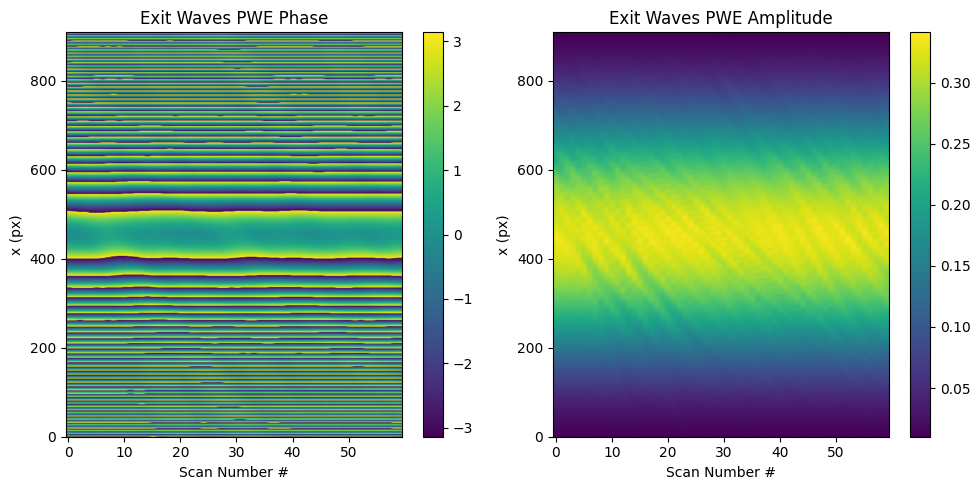

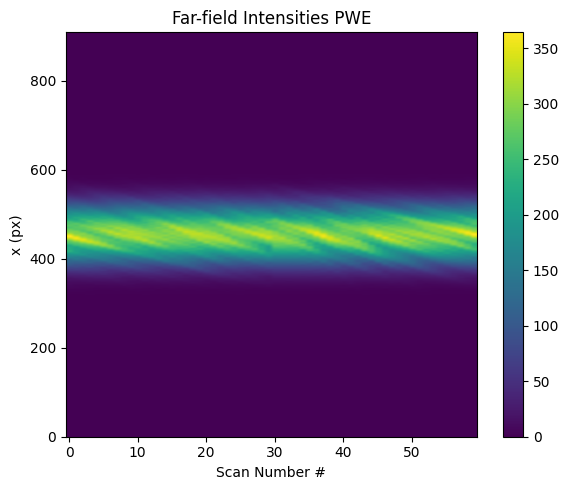

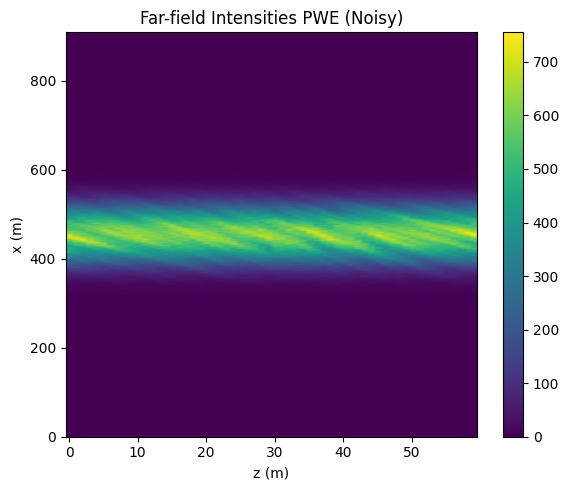

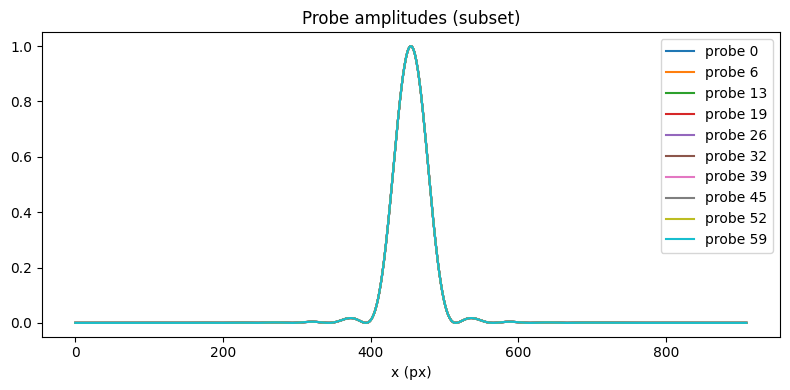

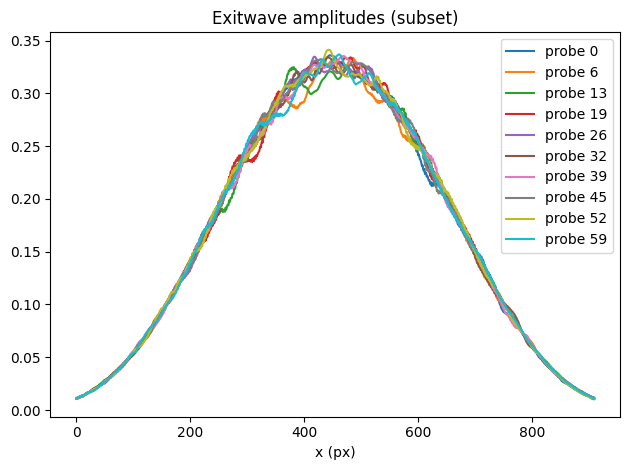

In [ ]:
original_shape = exit_waves.shape
target_shape = (original_shape[0], simulation_space.effective_nx)
zoom_factors = np.array(target_shape) / np.array(original_shape)

data_ew = zoom(exit_waves, zoom_factors, order=1)
data = np.abs(np.fft.fft(data_ew)) ** 2

print(f"Original exit waves shape: {exit_waves.shape}")
print(f"Coarse exit waves shape: {data_ew.shape}")

plot_data(
    data=data,
    exitwaves=data_ew,
    simulation_space=simulation_space,
    probes=ptycho_probes,
)

### 4. Reconstructs on Coarser nz Discretization
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

2025-12-14 15:43:30,612 - INFO - Initialized Multislice 3PIE Reconstructor.


2025-12-14 15:43:32,021 - INFO - [Iter 001] Mean Loss = 0.160405, Time = 1.41 seconds
2025-12-14 15:43:33,423 - INFO - [Iter 002] Mean Loss = 0.150867, Time = 1.40 seconds
2025-12-14 15:43:34,758 - INFO - [Iter 003] Mean Loss = 0.147512, Time = 1.33 seconds
2025-12-14 15:43:36,439 - INFO - [Iter 004] Mean Loss = 0.145730, Time = 1.68 seconds
2025-12-14 15:43:37,962 - INFO - [Iter 005] Mean Loss = 0.144610, Time = 1.52 seconds
2025-12-14 15:43:39,411 - INFO - [Iter 006] Mean Loss = 0.143835, Time = 1.45 seconds
2025-12-14 15:43:40,839 - INFO - [Iter 007] Mean Loss = 0.143266, Time = 1.43 seconds
2025-12-14 15:43:42,276 - INFO - [Iter 008] Mean Loss = 0.142829, Time = 1.44 seconds
2025-12-14 15:43:43,896 - INFO - [Iter 009] Mean Loss = 0.142482, Time = 1.62 seconds
2025-12-14 15:43:45,428 - INFO - [Iter 010] Mean Loss = 0.142201, Time = 1.53 seconds


Reconstruction time: 14.82 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for MS Reconstruction'}, xlabel='Iteration', ylabel='RMSE'>)

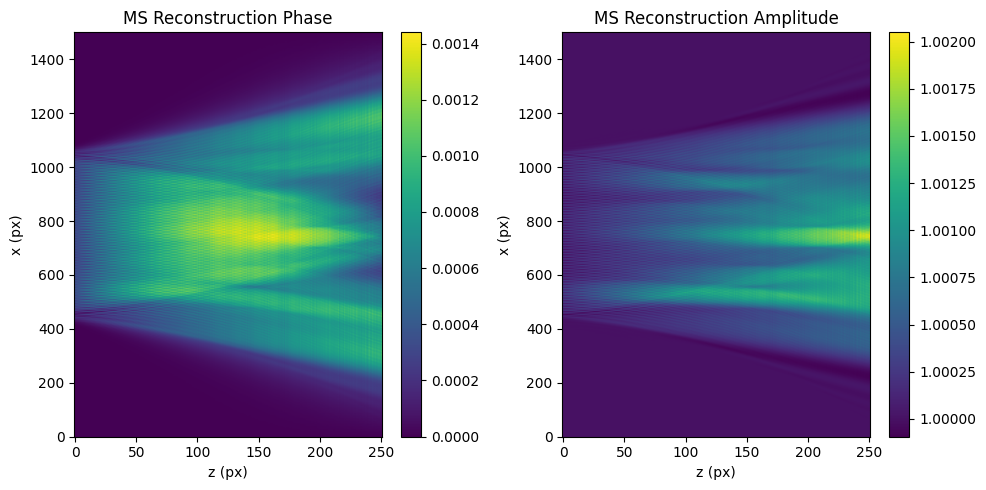

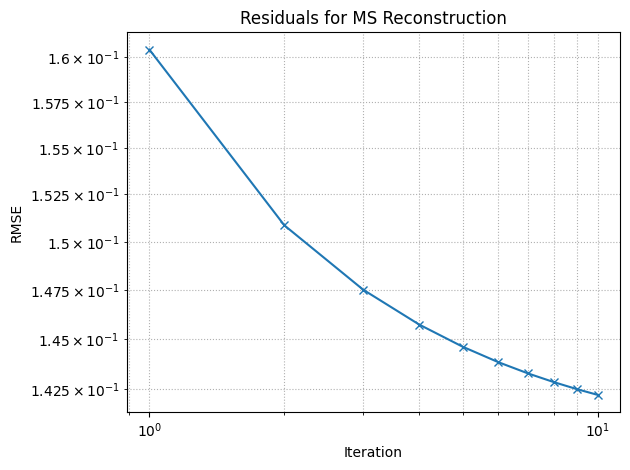

In [ ]:
recon_ms = ReconstructorMS(
    simulation_space, data_ew, phase_retrieval=False, verbose=True
)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=30, alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space.viewer.plot_two_panels(
    n_est_ms,
    view="phase_amp",
    title="MS Reconstruction",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_ms,
    title="Residuals for MS Reconstruction",
)

/home/dnz75396/thick_ptycho/thick_ptycho/forward_model/pwe/solvers/utils/_pint_utils.py:171: SparseEfficiencyWarning: splu converted its input to CSC format
  spla.splu((self.A_bar - (z * self.B_bar)).astype(self.dtype))
/home/dnz75396/thick_ptycho/thick_ptycho/forward_model/pwe/solvers/utils/_pint_utils.py:184: SparseEfficiencyWarning: splu converted its input to CSC format
  spla.splu((A_bar_H - (z_conj * B_bar_H)).astype(self.dtype))
2025-12-14 15:43:46,562 - INFO - Initializing Least Squares Solver...
2025-12-14 15:43:46,582 - INFO - Iteration 1/3
2025-12-14 15:43:49,782 - INFO -     RMSE: 0.10556006523355947
2025-12-14 15:44:03,373 - INFO -     Iteration 1 took 16.79 seconds.
2025-12-14 15:44:03,374 - INFO - Iteration 2/3
2025-12-14 15:44:14,383 - INFO -     RMSE: 0.09995897653222661
2025-12-14 15:44:52,607 - INFO -     Iteration 2 took 49.23 seconds.
2025-12-14 15:44:52,609 - INFO - Iteration 3/3
2025-12-14 15:45:01,712 - INFO -     RMSE: 0.09913474789492747
2025-12-14 15:45:46,4

Reconstruction time: 119.92 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for PWE Reconstruction'}, xlabel='Iteration', ylabel='RMSE'>)

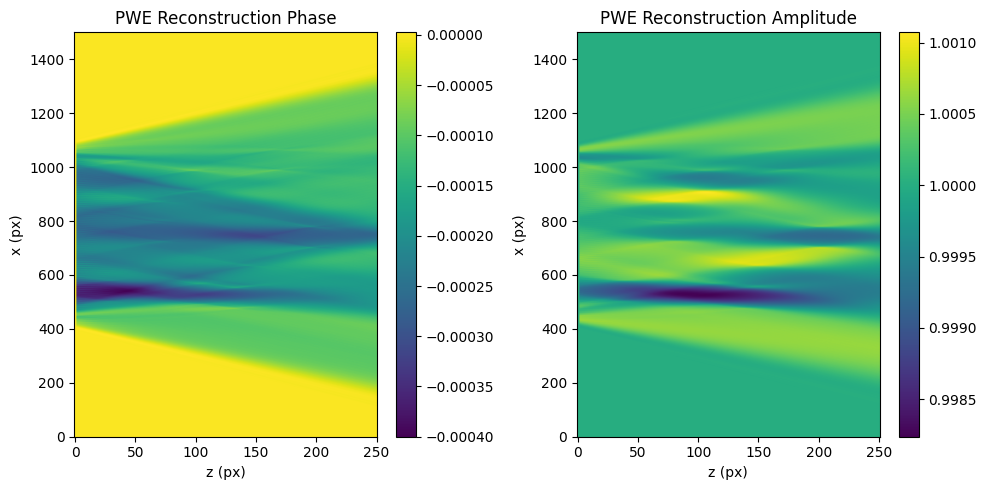

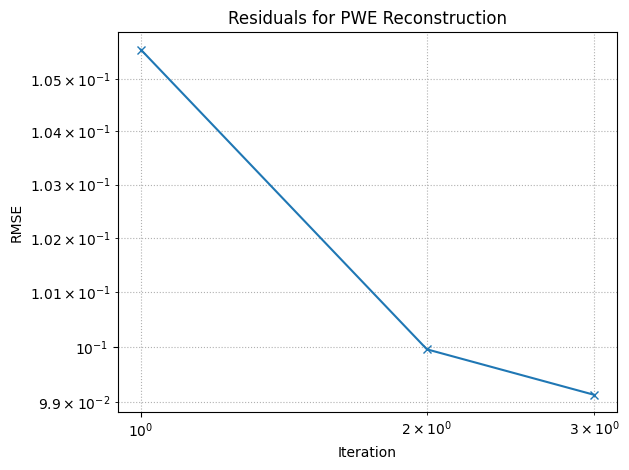

In [ ]:
atol = 1e-4
alpha = 1e-8
recon_pwe = ReconstructorPWE(
    simulation_space, data_ew, phase_retrieval=False, verbose=True, 
    solver_type="full",
    alpha=alpha,
    atol=atol,
)
time_start = time.time()
n_est_pwe, u, residual_pwe = recon_pwe.reconstruct(max_iters=30)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space.viewer.plot_two_panels(
    n_est_pwe,
    view="phase_amp",
    title="PWE Reconstruction",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_pwe,
    title="Residuals for PWE Reconstruction",
)

## Phase Retrieval

2025-12-14 15:45:47,335 - INFO - Initialized Multislice 3PIE Reconstructor.


2025-12-14 15:45:49,061 - INFO - [Iter 001] Mean Loss = 0.007846, Time = 1.72 seconds
2025-12-14 15:45:50,762 - INFO - [Iter 002] Mean Loss = 0.007063, Time = 1.70 seconds
2025-12-14 15:45:52,120 - INFO - [Iter 003] Mean Loss = 0.006759, Time = 1.36 seconds
2025-12-14 15:45:53,608 - INFO - [Iter 004] Mean Loss = 0.006602, Time = 1.49 seconds
2025-12-14 15:45:55,095 - INFO - [Iter 005] Mean Loss = 0.006510, Time = 1.49 seconds
2025-12-14 15:45:56,494 - INFO - [Iter 006] Mean Loss = 0.006453, Time = 1.40 seconds
2025-12-14 15:45:57,822 - INFO - [Iter 007] Mean Loss = 0.006416, Time = 1.33 seconds
2025-12-14 15:45:59,298 - INFO - [Iter 008] Mean Loss = 0.006393, Time = 1.47 seconds
2025-12-14 15:46:00,981 - INFO - [Iter 009] Mean Loss = 0.006378, Time = 1.68 seconds
2025-12-14 15:46:02,279 - INFO - [Iter 010] Mean Loss = 0.006369, Time = 1.30 seconds


Reconstruction time: 14.94 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for MS Reconstruction with Phase Retrieval'}, xlabel='Iteration', ylabel='RMSE'>)

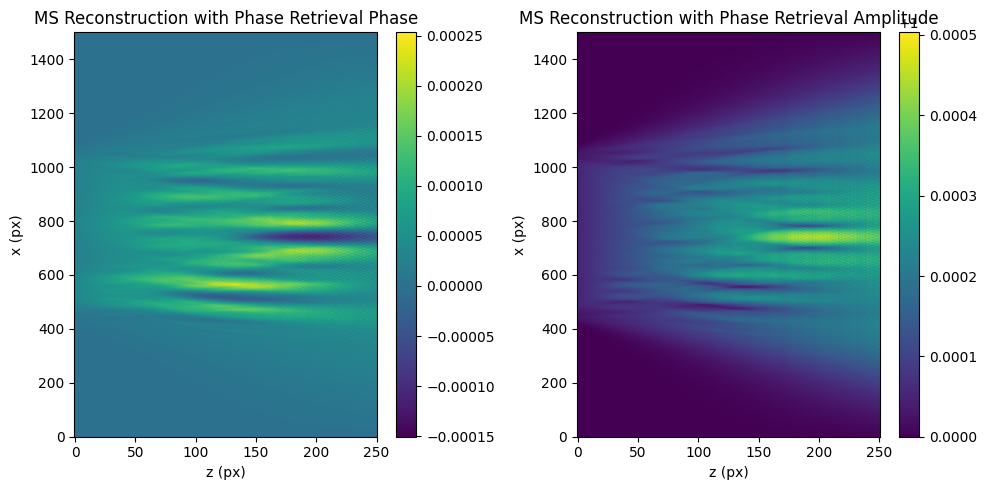

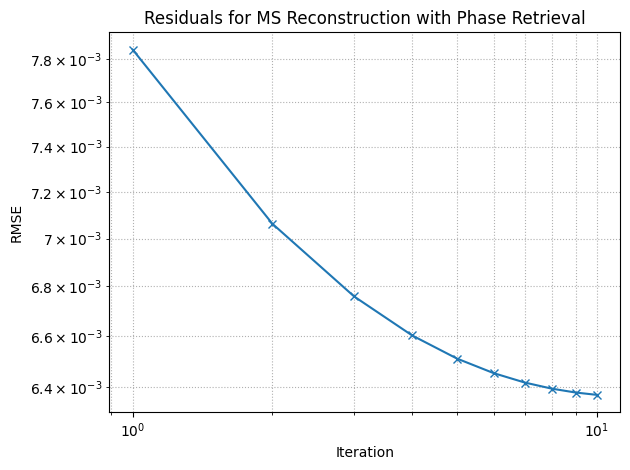

In [ ]:
recon_ms = ReconstructorMS(simulation_space, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=30, alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_ms,
    view="phase_amp",
    title="MS Reconstruction with Phase Retrieval",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_ms,
    title="Residuals for MS Reconstruction with Phase Retrieval",
)

2025-12-14 15:46:03,145 - INFO - Initializing Least Squares Solver...
2025-12-14 15:46:03,164 - INFO - Iteration 1/10
2025-12-14 15:46:05,569 - INFO -     RMSE: 0.00838109970952155
2025-12-14 15:46:16,323 - INFO -     Iteration 1 took 13.16 seconds.
2025-12-14 15:46:16,324 - INFO - Iteration 2/10
2025-12-14 15:46:26,838 - INFO -     RMSE: 0.006743574314967861
2025-12-14 15:46:52,514 - INFO -     Iteration 2 took 36.19 seconds.
2025-12-14 15:46:52,516 - INFO - Iteration 3/10
2025-12-14 15:47:02,488 - INFO -     RMSE: 0.006432189030962506
2025-12-14 15:47:26,983 - INFO -     Iteration 3 took 34.47 seconds.
2025-12-14 15:47:26,985 - INFO - Iteration 4/10
2025-12-14 15:47:36,979 - INFO -     RMSE: 0.006213632899893791
2025-12-14 15:48:02,762 - INFO -     Iteration 4 took 35.78 seconds.
2025-12-14 15:48:02,764 - INFO - Iteration 5/10
2025-12-14 15:48:17,315 - INFO -     RMSE: 0.00600259196400888
2025-12-14 15:48:45,255 - INFO -     Iteration 5 took 42.49 seconds.
2025-12-14 15:48:45,256 - I

Reconstruction time: 357.76 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for PWE Reconstruction with Phase Retrieval'}, xlabel='Iteration', ylabel='RMSE'>)

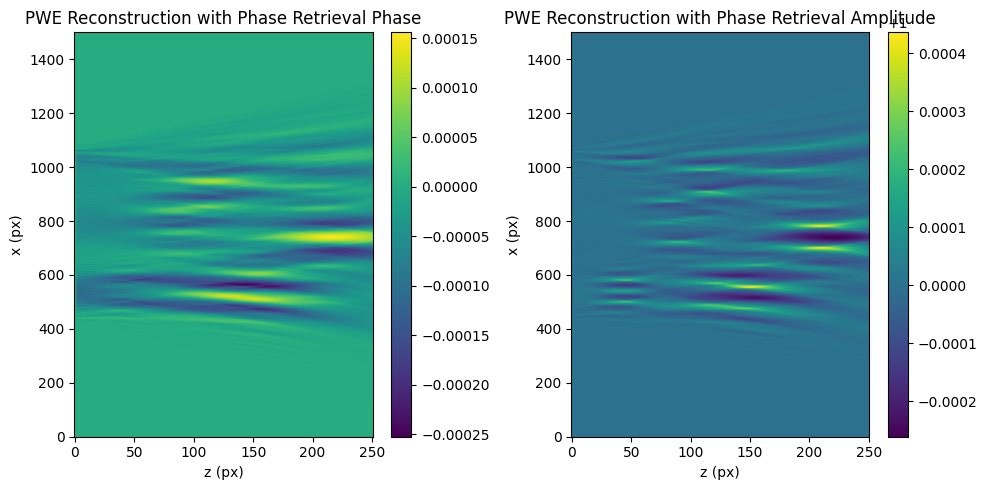

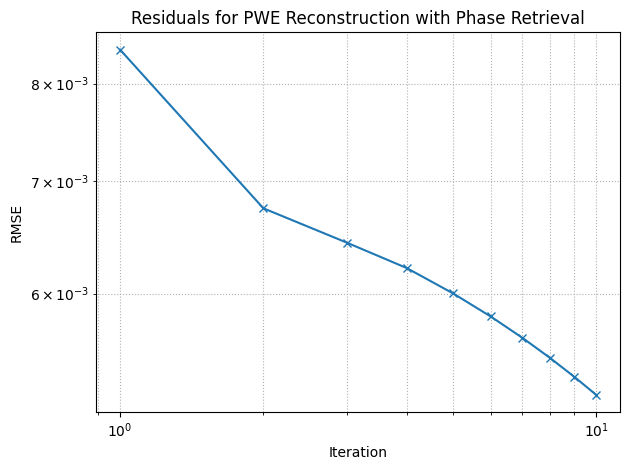

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space, data, phase_retrieval=True, verbose=True,
                             solver_type="full",
    alpha=alpha,
    atol=atol)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=30)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_pwe,
    view="phase_amp",
    title="PWE Reconstruction with Phase Retrieval",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_pwe,
    title="Residuals for PWE Reconstruction with Phase Retrieval",
)

# Phase Retrieval (noisy data)

In [ ]:
rng = np.random.default_rng(seed=42)
data_noisy = data.copy() + rng.poisson(np.abs(data))

2025-12-14 15:52:01,786 - INFO - Initialized Multislice 3PIE Reconstructor.


2025-12-14 15:52:03,438 - INFO - [Iter 001] Mean Loss = 0.067792, Time = 1.65 seconds
2025-12-14 15:52:05,089 - INFO - [Iter 002] Mean Loss = 0.044248, Time = 1.65 seconds
2025-12-14 15:52:06,612 - INFO - [Iter 003] Mean Loss = 0.032979, Time = 1.52 seconds
2025-12-14 15:52:08,334 - INFO - [Iter 004] Mean Loss = 0.027442, Time = 1.72 seconds
2025-12-14 15:52:10,011 - INFO - [Iter 005] Mean Loss = 0.025474, Time = 1.68 seconds
2025-12-14 15:52:14,563 - INFO - [Iter 006] Mean Loss = 0.025694, Time = 4.55 seconds
2025-12-14 15:52:16,220 - INFO - [Iter 007] Mean Loss = 0.027090, Time = 1.66 seconds
2025-12-14 15:52:17,938 - INFO - [Iter 008] Mean Loss = 0.029028, Time = 1.72 seconds
2025-12-14 15:52:19,519 - INFO - [Iter 009] Mean Loss = 0.031164, Time = 1.58 seconds
2025-12-14 15:52:21,054 - INFO - [Iter 010] Mean Loss = 0.033324, Time = 1.53 seconds


Reconstruction time: 19.27 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for MS Reconstruction with Phase Retrieval (Noisy Data)'}, xlabel='Iteration', ylabel='RMSE'>)

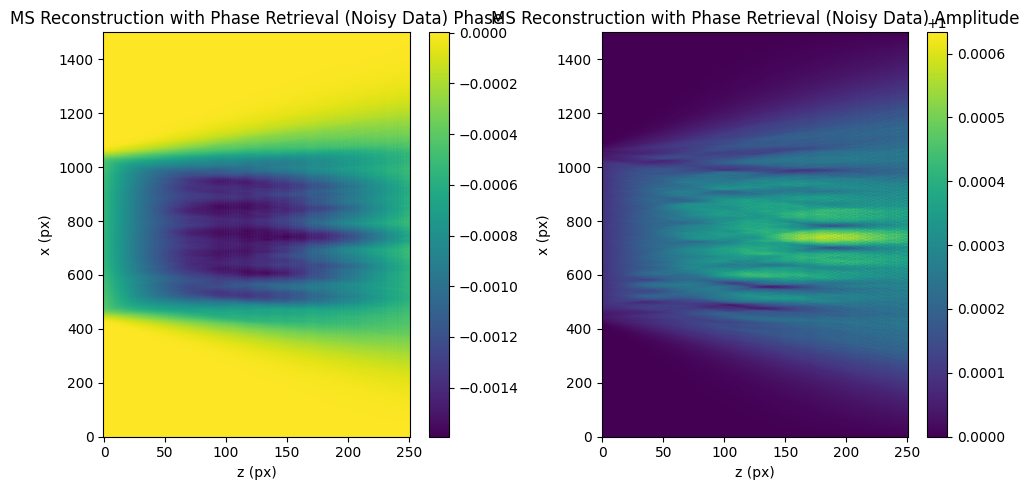

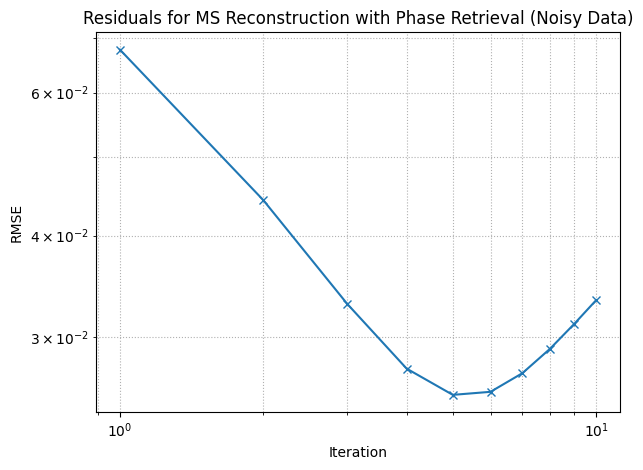

In [ ]:
recon_ms = ReconstructorMS(
    simulation_space, data_noisy, phase_retrieval=True, verbose=True
)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=30, alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_ms,
    view="phase_amp",
    title="MS Reconstruction with Phase Retrieval (Noisy Data)",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_ms,
    title="Residuals for MS Reconstruction with Phase Retrieval (Noisy Data)",
)

In [ ]:
recon_pwe = ReconstructorPWE(
    simulation_space, data_noisy, phase_retrieval=True, verbose=True,
    solver_type="full",
    alpha=alpha,
    atol=atol,
)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=30)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_pwe,
    view="phase_amp",
    title="PWE Reconstruction with Phase Retrieval (Noisy Data)",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_pwe,
    title="Residuals for PWE Reconstruction with Phase Retrieval (Noisy Data)",
)

2025-12-14 15:52:22,083 - INFO - Initializing Least Squares Solver...
2025-12-14 15:52:22,098 - INFO - Iteration 1/10
2025-12-14 15:52:24,872 - INFO -     RMSE: 0.0812204580075757
2025-12-14 15:52:34,467 - INFO -     Iteration 1 took 12.37 seconds.
2025-12-14 15:52:34,467 - INFO - Iteration 2/10
